# GGL of UNIONS galaxies by AGNs

This notebook plots the results of the first measurements of galaxy-galaxy lensing between SDSS AGN and UNIONS 3500 deg^2 catalogs.

In [1]:
%matplotlib inline

In [2]:
import os

import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.io import ascii

from sp_validation import plots

## Variables

In [3]:
# Split catalogue into mass bins
n_split = 1

### Output

In [4]:
output_path = './SP'
output_cc_base = 'ggl_agn'

### Units

In [5]:
sep_units = 'arcmin'

### Input catalogue type

In [6]:
weight = True

if weight:
    str_w = '_w'
else:
    str_w = ''

In [7]:
output_base = f'{output_path}/{output_cc_base}_'
output_suff = f'n_split_{n_split}{str_w}'

In [8]:
# Read correlation data file and assign quantities of interest
data_cc_list = []
for idx in range(n_split):
    cc_name = f'{output_base}{idx}_{output_suff}.fits'
    print(f'Reading {cc_name}')
    f = fits.open(cc_name)
    data_cc = f[1].data
    data_cc_list.append(data_cc)

Reading ./SP/ggl_agn_0_n_split_1_w.fits


## Plotting

In [9]:
xlabel = rf'$\theta$ [{sep_units}]'
ylabel = r'$\gamma(\theta)$'
title = f'UNIONS - SDSS AGNs GGL weighted={weight}'

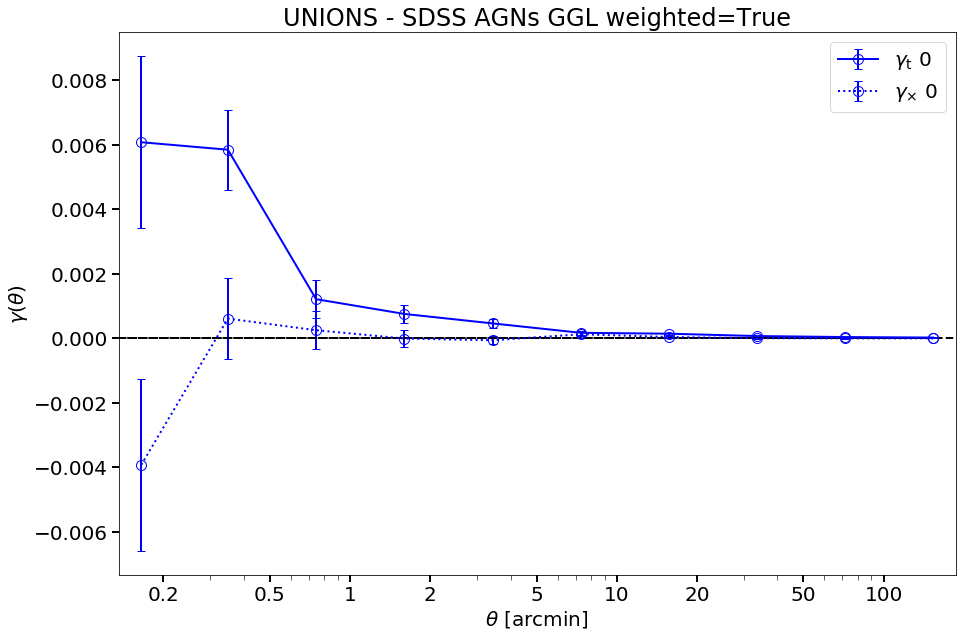

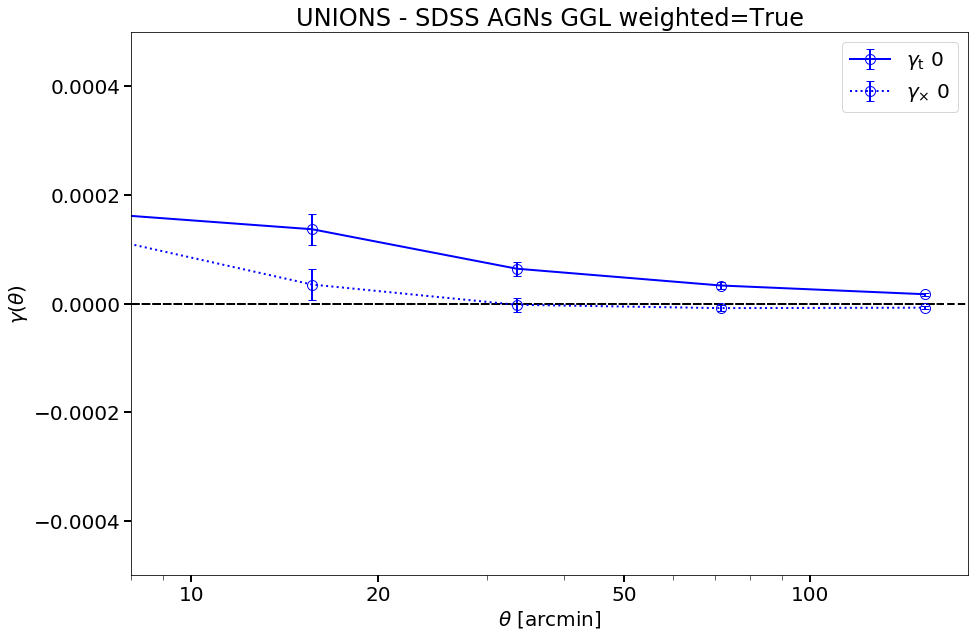

In [10]:
# Linear plot

x = []
y = []
dy = []
labels = []

fx = 1.05

colors = ['b', 'b', 'orange', 'orange']
linestyles = ['-', ':'] * 2

my_fx = 1
for idx in range(n_split):
    data_cc = data_cc_list[idx]
    
    x.extend([data_cc['meanr'] * my_fx] * 2)
    
    y.append(data_cc['gamT'])
    y.append(data_cc['gamX'])
    
    dy.extend([data_cc['sigma']] * 2)

    labels.append(rf'$\gamma_{{\rm t}}$ {idx}')
    labels.append(rf'$\gamma_{{\times}}$ {idx}')
    
    my_fx *= fx

xmin = np.min(np.ravel(x),axis=0) / fx**4
xmax = np.max(np.ravel(x),axis=0) * fx**4

plots.plot_data_1d(
    x,
    y,
    dy,
    title,
    xlabel,
    ylabel,
    f'{output_base}{output_suff}.pdf',
    xlog=True,
    labels=labels,
    colors=colors,
    linestyles=linestyles,
    xlim=[xmin, xmax],
)

plots.plot_data_1d(
    x,
    y,
    dy,
    title,
    xlabel,
    ylabel,
    f'{output_base}{output_suff}_zoom.pdf',
    xlog=True,
    labels=labels,
    colors=colors,
    linestyles=linestyles,
    xlim=[8, 180],
    ylim=[-0.0005, 0.0005]
)

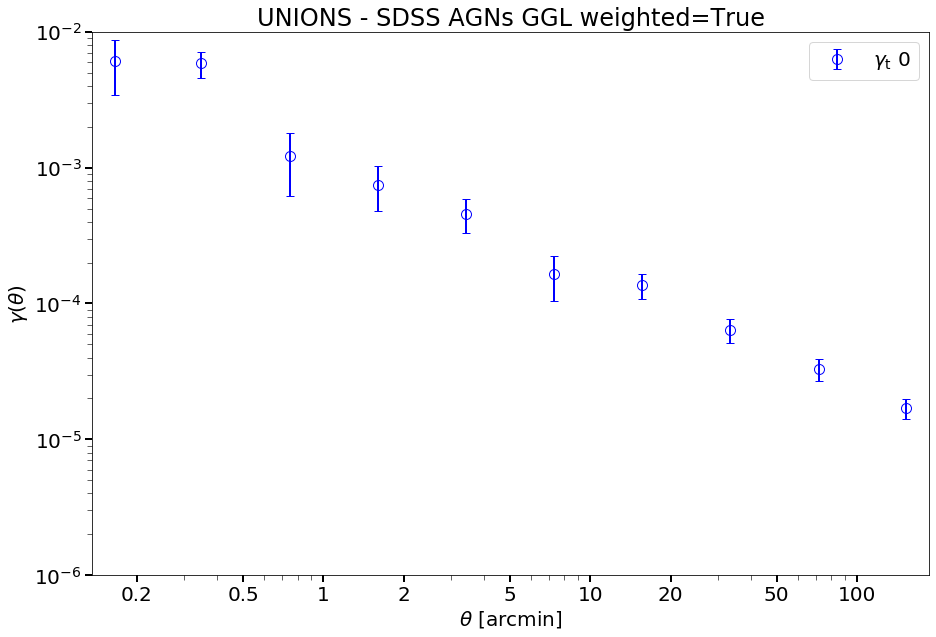

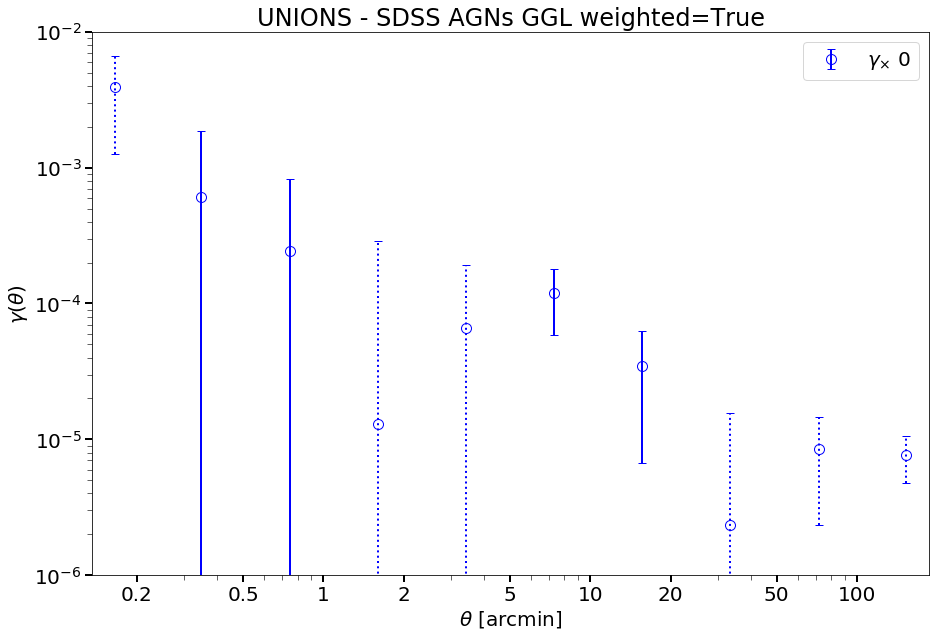

In [11]:
# y-log plot of <gamma_t>

colors = ['b', 'b', 'orange', 'orange']
linestyles = ['-', ':'] * 2
ylim = [1e-6, 1e-2]

for mode, lab in zip(['T', 'X'], [r'\rm t', r'\times']):
    
    x = []
    y = []
    dy = []
    labels = []

    my_fx = 1
    for idx in range(n_split):
        data_cc = data_cc_list[idx]
    
        w = data_cc[f'gam{mode}'] >= 0
        x.append(data_cc['meanr'][w] * my_fx)
        y.append(data_cc[f'gam{mode}'][w])
        dy.append(data_cc['sigma'][w])
    
        w = data_cc[f'gam{mode}'] < 0
        x.append(data_cc['meanr'][w] * my_fx)
        y.append(-data_cc[f'gam{mode}'][w])
        
        dy.append(data_cc['sigma'][w])

        labels.append(rf'$\gamma_{{{lab}}}$ {idx}')
        labels.append('')
    
        my_fx *= fx
  
    plots.plot_data_1d(
        x,
        y,
        dy,
        title,
        xlabel,
        ylabel,
        f'{output_base}{output_suff}_g{mode}_log.pdf',
        xlog=True,
        ylog=True,
        labels=labels,
        colors=colors,
        linestyles=[''] * 4,
        eb_linestyles=linestyles,
        xlim=[xmin, xmax],
        ylim=ylim,
    )